In [2]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [3]:
(train_images, _), (test2_images, _) = tf.keras.datasets.mnist.load_data()

In [4]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test2_images)

Text(0.5, 0.77, 'First 3 test images')

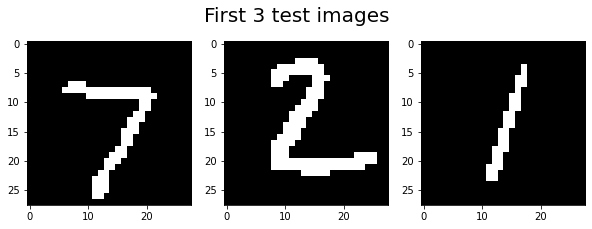

In [5]:
fig, axes = plt.subplots(1,3,figsize=(10,6))
for i,ax in enumerate(axes):
    ax.imshow(test_images[i].squeeze(),cmap='gray')
    
fig.suptitle('First 3 test images',fontsize=20,y=0.77)

In [6]:
train_size = 60000
batch_size = 32
test_size = 10000

In [7]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

In [8]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

## Define the loss function and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, we optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

**Note**: we could also analytically compute the KL term, but here we incorporate all three terms in the Monte Carlo estimator for simplicity.

In [9]:
optimizer = tf.keras.optimizers.Adam(1e-4)
# optimizer = tf.keras.optimizers.Nadam() 

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

In [10]:
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [11]:
@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Training

* We start by iterating over the dataset
* During each iteration, we pass the image to the encoder to obtain a set of mean and log-variance parameters of the approximate posterior $q(z|x)$
* We then apply the *reparameterization trick* to sample from $q(z|x)$
* Finally, we pass the reparameterized samples to the decoder to obtain the logits of the generative distribution $p(x|z)$
* **Note:** Since we use the dataset loaded by keras with 60k datapoints in the training set and 10k datapoints in the test set, our resulting ELBO on the test set is slightly higher than reported results in the literature which uses dynamic binarization of Larochelle's MNIST.

### Generating images

* After training, it is time to generate some images
* We start by sampling a set of latent vectors from the unit Gaussian prior distribution $p(z)$
* The generator will then convert the latent sample $z$ to logits of the observation, giving a distribution $p(x|z)$
* Here we plot the probabilities of Bernoulli distributions


In [12]:
epochs = 100
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 32
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model1 = CVAE(latent_dim)

In [13]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
#   plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [14]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

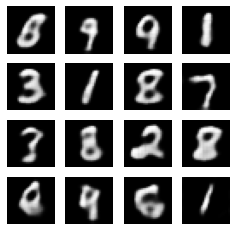

KeyboardInterrupt: 

In [18]:
generate_and_save_images(model1, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model1, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model1, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model1, epoch, test_sample)

In [ ]:
num = 
test_samples = test_images[num:3+num]

In [ ]:
def get_preds(test_samples):
    mean, logvar = model.encode(test_samples)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    return predictions

In [ ]:
fig, axes = plt.subplots(1,3,figsize=(10,6))
for i,ax in enumerate(axes):
    ax.imshow(get_preds(test_samples)[i].numpy().squeeze(),cmap='gray')
    
fig.suptitle('First 3 test images',fontsize=20,y=0.77)

### Display a generated image from the last training epoch

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

### Display an animated GIF of all the saved images

In [ ]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

### Display a 2D manifold of digits from the latent space

Running the code below will show a continuous distribution of the different digit classes, with each digit morphing into another across the 2D latent space. We use [TensorFlow Probability](https://www.tensorflow.org/probability) to generate a standard normal distribution for the latent space.

In [ ]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

In [ ]:
plot_latent_images(model, 20)

## Next steps

This tutorial has demonstrated how to implement a convolutional variational autoencoder using TensorFlow. 

As a next step, you could try to improve the model output by increasing the network size. 
For instance, you could try setting the `filter` parameters for each of the `Conv2D` and `Conv2DTranspose` layers to 512. 
Note that in order to generate the final 2D latent image plot, you would need to keep `latent_dim` to 2. Also, the training time would increase as the network size increases.

You could also try implementing a VAE using a different dataset, such as CIFAR-10.

VAEs can be implemented in several different styles and of varying complexity. You can find additional implementations in the following sources:
- [Variational AutoEncoder (keras.io)](https://keras.io/examples/generative/vae/)
- [VAE example from "Writing custom layers and models" guide (tensorflow.org)](https://www.tensorflow.org/guide/keras/custom_layers_and_models#putting_it_all_together_an_end-to-end_example)
- [TFP Probabilistic Layers: Variational Auto Encoder](https://www.tensorflow.org/probability/examples/Probabilistic_Layers_VAE)

If you'd like to learn more about the details of VAEs, please refer to [An Introduction to Variational Autoencoders](https://arxiv.org/abs/1906.02691).